<a href="https://colab.research.google.com/github/IlyessAgg/mLproject/blob/main/Aerial_Image_Segmentation_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 35.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

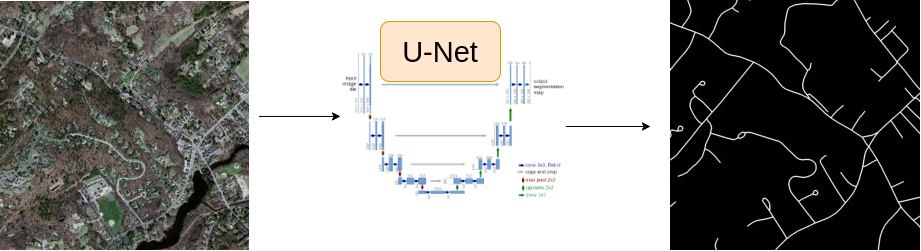

# Download Subset Dataset

In [ ]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411
Receiving objects: 100% (411/411), 851.74 MiB | 14.13 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (401/401), done.


# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE = "/content/Road_seg_dataset/train.csv"
DATA_DIR = "/content/Road_seg_dataset/"

DEVICE = 'cuda'

IMG_SIZE = 512
BATCH_SIZE = 8
EPOCHS = 25
LR = 0.001

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [ ]:
idx = 2

row = df.iloc[idx]

image_path = DATA_DIR + row.images
mask_path = DATA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

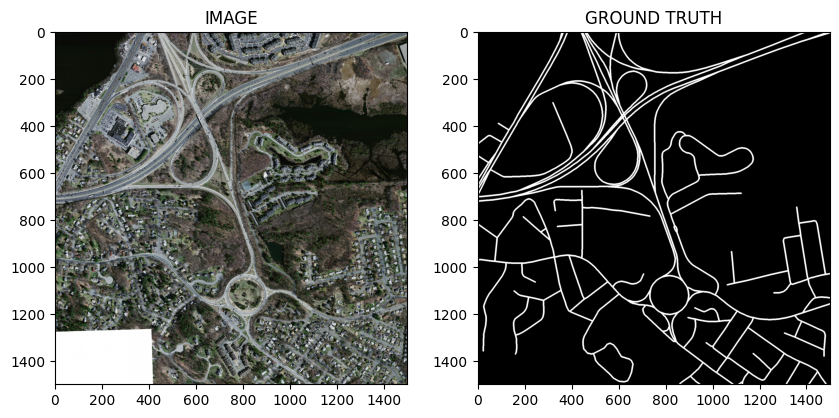

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ])

# Task 4 : Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations=None):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    image_path = DATA_DIR + row.images
    mask_path = DATA_DIR + row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # (h, w, c)
    mask = np.expand_dims(mask, axis=-1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    # (h, w, c) -> (c, h, w)

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 159
Size of Validset : 40


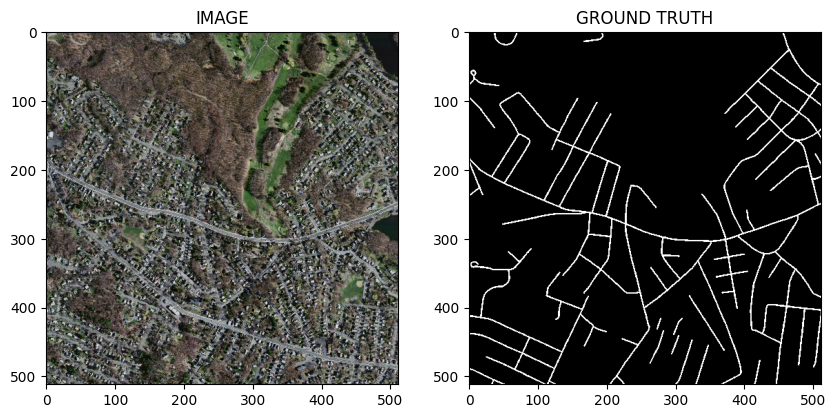

In [ ]:
idx = 20

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE, shuffle = False)

In [ ]:
print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 20
Total no. of batches in validloader : 5


In [ ]:
for image, mask in trainloader:
  break

print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([8, 3, 512, 512])
One batch mask shape : torch.Size([8, 1, 512, 512])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3,
        classes=1,
        activation = None
    )

  def forward(self, images, masks=None):

    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits

In [ ]:
model = SegmentationModel()
model.to(DEVICE);

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 411MB/s]


# Task 7 : Create Train and Validation Function

In [ ]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [ ]:
def eval_fn(data_loader, model):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()

  return total_loss / len(data_loader)

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("SAVED MODEL")
    best_valid_loss = valid_loss

  print(f"Epoch : {i+1} Train_loss : {train_loss} Valid loss : {valid_loss}")

100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


SAVED MODEL
Epoch : 1 Train_loss : 1.194204956293106 Valid loss : 1.0949843645095825


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


SAVED MODEL
Epoch : 2 Train_loss : 0.9234672009944915 Valid loss : 0.9365307927131653


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


SAVED MODEL
Epoch : 3 Train_loss : 0.796029019355774 Valid loss : 0.8392386198043823


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


SAVED MODEL
Epoch : 4 Train_loss : 0.7200013488531113 Valid loss : 0.778628659248352


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


SAVED MODEL
Epoch : 5 Train_loss : 0.6922583907842637 Valid loss : 0.7730321407318115


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


SAVED MODEL
Epoch : 6 Train_loss : 0.6738757818937302 Valid loss : 0.683248507976532


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Epoch : 7 Train_loss : 0.6401244103908539 Valid loss : 0.7101455092430115


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch : 8 Train_loss : 0.6379509717226028 Valid loss : 0.6926621794700623


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch : 9 Train_loss : 0.6249694555997849 Valid loss : 0.6975862622261048


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


SAVED MODEL
Epoch : 10 Train_loss : 0.6195317476987838 Valid loss : 0.6479013323783874


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Epoch : 11 Train_loss : 0.6123827874660492 Valid loss : 0.6799777746200562


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


SAVED MODEL
Epoch : 12 Train_loss : 0.5989337399601936 Valid loss : 0.6431803464889526


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Epoch : 13 Train_loss : 0.6045669138431549 Valid loss : 0.6441880345344544


100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


Epoch : 14 Train_loss : 0.5869615018367768 Valid loss : 0.6552590131759644


100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


Epoch : 15 Train_loss : 0.5905993521213532 Valid loss : 0.6889153003692627


100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


Epoch : 16 Train_loss : 0.5794998645782471 Valid loss : 0.6503987073898315


100%|██████████| 5/5 [00:04<00:00,  1.25it/s]


SAVED MODEL
Epoch : 17 Train_loss : 0.5800446331501007 Valid loss : 0.630035150051117


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


SAVED MODEL
Epoch : 18 Train_loss : 0.5665498211979866 Valid loss : 0.6242404460906983


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch : 19 Train_loss : 0.5757049083709717 Valid loss : 0.6375396728515625


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


SAVED MODEL
Epoch : 20 Train_loss : 0.5578846707940102 Valid loss : 0.6174345493316651


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


Epoch : 21 Train_loss : 0.5595340937376022 Valid loss : 0.6418305277824402


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch : 22 Train_loss : 0.559681361913681 Valid loss : 0.6532750368118286


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


SAVED MODEL
Epoch : 23 Train_loss : 0.5526573970913887 Valid loss : 0.6109024286270142


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch : 24 Train_loss : 0.5521777778863907 Valid loss : 0.6176525235176087


100%|██████████| 5/5 [00:04<00:00,  1.14it/s]

Epoch : 25 Train_loss : 0.5314434185624123 Valid loss : 0.6199624180793762


# Task 9 : Inference

In [ ]:
model.load_state_dict(torch.load('/content/best_model.pt'))

<All keys matched successfully>

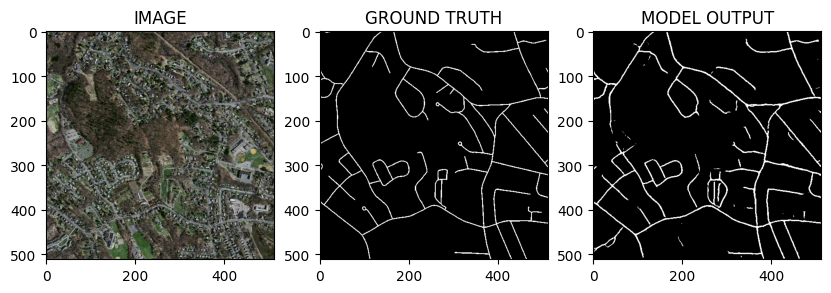

In [ ]:
idx = 14

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(c, h, w) -> (1, c, h, w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))